In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_json('/content/drive/MyDrive/Sarcasm_Headlines_Dataset.json', lines =True)
df.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [3]:
df = df[['headline','is_sarcastic']]
df.head()

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


In [4]:
df.to_csv('sarcasm_headlines.csv',index = False)

In [5]:
df.head()

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


In [6]:
df.shape

(26709, 2)

In [7]:
df['is_sarcastic'].value_counts()

,count
is_sarcastic,
0,14985
1,11724


In [8]:
from sklearn.model_selection import train_test_split

X = df['headline']
y = df['is_sarcastic']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = 42)

In [9]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((21367,), (5342,), (21367,), (5342,))

In [10]:
import tensorflow as tf
from transformers import TFDistilBertForSequenceClassification, DistilBertTokenizer

In [11]:
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTr

In [12]:
example = df['headline'].iloc[0]
example

"former versace store clerk sues over secret 'black code' for minority shoppers"

In [13]:
tokenized_example = tokenizer(example)
tokenized_example

{'input_ids': [101, 2280, 18601, 3401, 3573, 7805, 9790, 2015, 2058, 3595, 1005, 2304, 3642, 1005, 2005, 7162, 4497, 7347, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [14]:
tokenized_example = tokenizer(example,return_tensors = 'tf')
tokenized_example

{'input_ids': <tf.Tensor: shape=(1, 19), dtype=int32, numpy=
array([[  101,  2280, 18601,  3401,  3573,  7805,  9790,  2015,  2058,
         3595,  1005,  2304,  3642,  1005,  2005,  7162,  4497,  7347,
          102]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(1, 19), dtype=int32, numpy=
array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
      dtype=int32)>}

In [15]:
max_length = max([len(tokenizer.encode(text)) for text in df['headline']])
max_length

66

In [16]:
X_train_encoded = tokenizer(list(X_train),padding = 'max_length',truncation = True,max_length = max_length,return_tensors ='tf')
X_test_encoded = tokenizer(list(X_test),padding = 'max_length',truncation = True,max_length = max_length,return_tensors ='tf')

In [17]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    {key: tf.convert_to_tensor(val) for key, val in X_train_encoded.items()},
    tf.convert_to_tensor(y_train)
))

test_dataset = tf.data.Dataset.from_tensor_slices((
    {key: tf.convert_to_tensor(val) for key, val in X_test_encoded.items()},
    tf.convert_to_tensor(y_test)
))

In [18]:
model.get_layer('distilbert').trainable = False

In [19]:
from tensorflow import keras

model.compile(optimizer= keras.optimizers.Adam(1e-4),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[keras.metrics.SparseCategoricalAccuracy()])

In [20]:
model.summary()

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
 dropout_19 (Dropout)        multiple                  0 (unused)
                                                                 
Total params: 66955010 (255.41 MB)
Trainable params: 592130 (2.26 MB)
Non-trainable params: 66362880 (253.15 MB)
_________________________________________________________________


In [21]:
history = model.fit(
    train_dataset.shuffle(len(train_dataset)).batch(16),
    epochs=10,
    validation_data=test_dataset.batch(16)
)

Epoch 1/10
1336/1336 [==============================] - 92s 55ms/step - loss: 0.4413 - sparse_categorical_accuracy: 0.8002 - val_loss: 0.3628 - val_sparse_categorical_accuracy: 0.8413
Epoch 2/10
1336/1336 [==============================] - 73s 55ms/step - loss: 0.3610 - sparse_categorical_accuracy: 0.8422 - val_loss: 0.3345 - val_sparse_categorical_accuracy: 0.8519
Epoch 3/10
1336/1336 [==============================] - 72s 54ms/step - loss: 0.3406 - sparse_categorical_accuracy: 0.8501 - val_loss: 0.3164 - val_sparse_categorical_accuracy: 0.8592
Epoch 4/10
1336/1336 [==============================] - 73s 54ms/step - loss: 0.3279 - sparse_categorical_accuracy: 0.8546 - val_loss: 0.3224 - val_sparse_categorical_accuracy: 0.8592
Epoch 5/10
1336/1336 [==============================] - 73s 55ms/step - loss: 0.3159 - sparse_categorical_accuracy: 0.8626 - val_loss: 0.2974 - val_sparse_categorical_accuracy: 0.8682
Epoch 6/10
1336/1336 [==============================] - 72s 54ms/step - loss: 0.

In [22]:
epochs = range(1,11)
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['sparse_categorical_accuracy']
val_accuracy = history.history['val_sparse_categorical_accuracy']

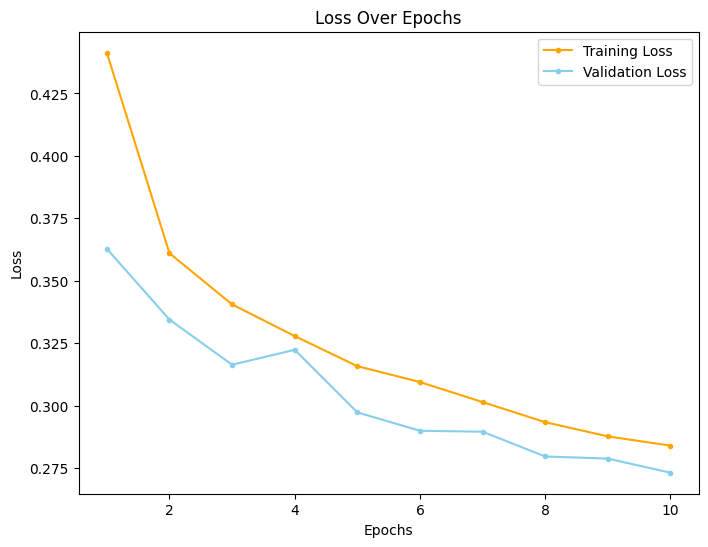

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(epochs, train_loss, label='Training Loss', color = 'orange',marker='.')
plt.plot(epochs, val_loss, label='Validation Loss', color = 'skyblue',marker='.')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

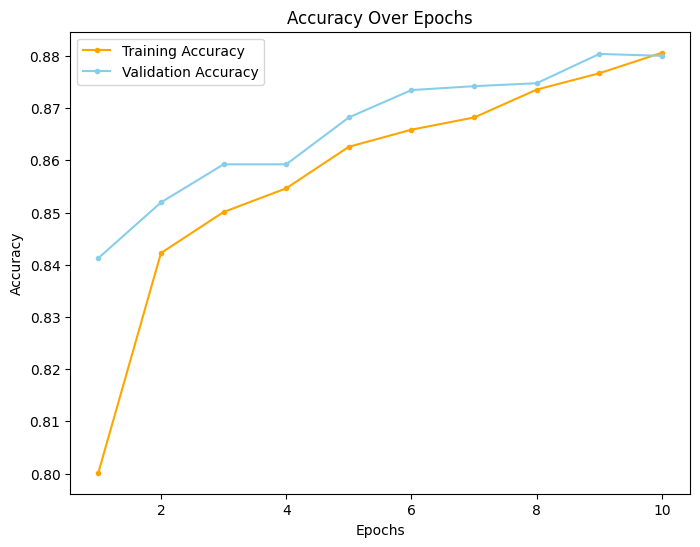

In [24]:
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_accuracy,label='Training Accuracy',color='orange',marker='.')
plt.plot(epochs, val_accuracy,label='Validation Accuracy',color='skyblue',marker='.')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [25]:
from sklearn.metrics import classification_report, confusion_matrix

334/334 [==============================] - 15s 42ms/step


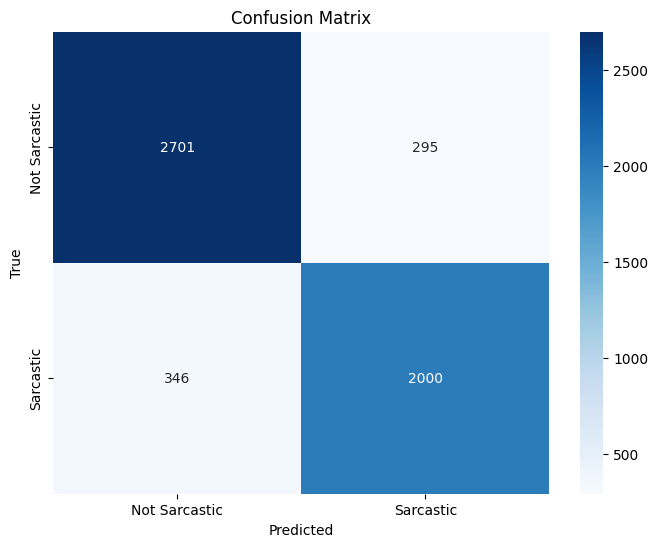

In [28]:
import seaborn as sns

y_pred = model.predict(test_dataset.batch(16))
y_pred_classes = np.argmax(y_pred.logits, axis=1)
cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Sarcastic', 'Sarcastic'],
            yticklabels=['Not Sarcastic', 'Sarcastic'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [29]:
accuracy = np.sum(y_pred_classes == y_test) / len(y_test)
print(f"Accuracy : {accuracy}")

Accuracy : 0.8800074878322726


In [30]:
print(classification_report(y_test, y_pred_classes))

              precision    recall  f1-score   support

           0       0.89      0.90      0.89      2996
           1       0.87      0.85      0.86      2346

    accuracy                           0.88      5342
   macro avg       0.88      0.88      0.88      5342
weighted avg       0.88      0.88      0.88      5342



In [31]:
model.save_pretrained('/content/drive/MyDrive/sarcasm_detection_model')
tokenizer.save_pretrained('/content/drive/MyDrive/sarcasm_detection_model')

('/content/drive/MyDrive/sarcasm_detection_model/tokenizer_config.json',
 '/content/drive/MyDrive/sarcasm_detection_model/special_tokens_map.json',
 '/content/drive/MyDrive/sarcasm_detection_model/vocab.txt',
 '/content/drive/MyDrive/sarcasm_detection_model/added_tokens.json')